# Tutorial : Spectral analysis of stochastic processes
- The material for this tutorial is available at http://bit.ly/1WMbAOX, make sure to put the lib subdirectory in your path with a line like this:

In [1]:
import numpy as np
from scipy.signal import welch,butter,lfilter

The following command triggers inline plot

In [2]:
import matplotlib.pyplot as plt

We first generate N time points for K realizations of an i.i.d. gaussian noise with zero mean and variance one.

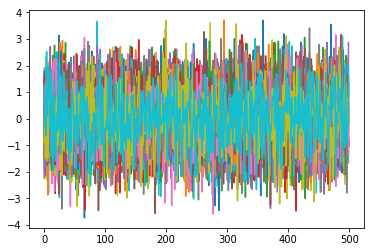

In [4]:
# Duration of the signals
N = 500
# Number of realizations
K = 40
x = np.random.randn(N,K)
plt.plot(x)
plt.show()


Let us plot the Periodogram 
$$
P_N(x)=\frac{1}{N}|F_N x|^2
$$
of these K realizations.

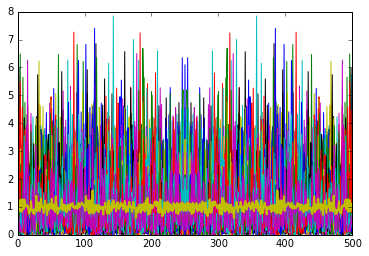

In [106]:
plt.plot(np.abs(np.fft.fft(x,axis=0))**2/N)
plt.plot(np.mean(np.abs(np.fft.fft(x,axis=0))**2,axis=1)/N,linewidth=2)
plt.show()

We see that the periodogram is not a good estimate of the Power Spectral Density, because its values fluctuate a lot. However, we notice by averaging the periodogram of several realizations that the empirical mean gets close to the expected constant PSD, this constant being the variance of the signal, i.e. one.

In order to have a better estimate of the PSD, we use the Welch periodogram.

In [107]:
help(welch)

Help on function welch in module scipy.signal.spectral:

welch(x, fs=1.0, window='hanning', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
    Estimate power spectral density using Welch's method.
    
    Welch's method [1]_ computes an estimate of the power spectral density
    by dividing the data into overlapping segments, computing a modified
    periodogram for each segment and averaging the periodograms.
    
    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. See `get_window` for a list of windows and
        required parameters. If `window` is array_like it will be used
        directly as the window and its length will be used for nperseg.
        Defaults to 'hanning'.
    nperseg : int, optional
        

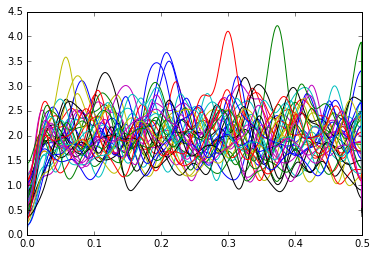

(513, 40)

In [115]:
[f,Pxx] = welch(x,axis=0,nperseg=50,nfft=1024)
plt.plot(f,Pxx)
#plt.ylim([0, 5])
plt.show()
Pxx.shape

The result, using the default parameters of pwelch, clearly reduces the fluctuations with respect to the periodogram estimate.

To better understand how to use pwelch, we now generate a *colored* signal by filtering a white noise using a butterworth band-pass filter. Note that when we plot the realizations of this signal, we observe oscillatory fluctuations reflecting the non-zero auto-correlation for non-zero lags.


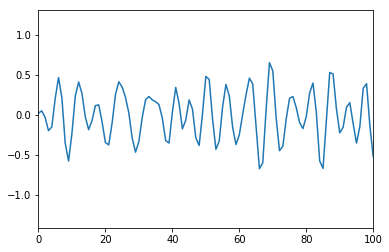

In [9]:
[brd,ard] = butter(3,np.array([.2, .4]),'bandpass')
y=lfilter(brd,ard,x,axis=0)
plt.plot(y[:,4])
plt.xlim([0, 100])
plt.show()



By computing the impulse response of the filter $h$, we can infer the PSD of the filtered noise as
$$
S_y(\nu) = |h(\nu)|^2
$$


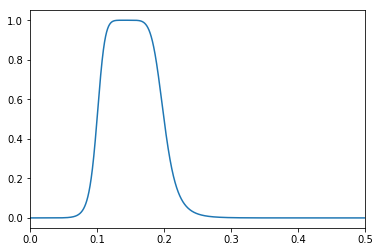

In [10]:
dirac = np.zeros([10000,1])
dirac[0] = 1
impresp = lfilter(brd,ard,dirac,axis=0);
irFreqAx = np.arange(len(impresp))/len(impresp); 
plt.plot(irFreqAx,np.abs(np.fft.fft(impresp,axis=0))**2)
plt.xlim([0, .5])
plt.show()

Now we try to estimate the PSD using pwelch. The main parameter of pwelch that we can modulate to affect the estimation procedure is the length of the time window $winLength$ that is used to compute individual periodograms before averaging them. 

The smaller the length of the time window, the coarser is the frequency resolution of the estimate. The can is due to the limitation of the DTF that is applied on each time window, and whose frequency resolution is typically $\frac{1}{winLength}$, i.e. the grid step of the DFT. On the other hand, dividing the time interval using smaller length time windows leads to more time windows, which lead to a greater reduction of the fluctuations of the estimator after averaging the periodograms.

We first use a large time window.


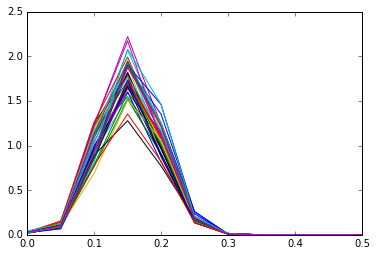

In [131]:
[freq,pwy] = welch(y,axis=0,nperseg=20);
plt.plot(freq,pwy)
plt.show()

The fluctuations are still large. Now we reduce the length of the time window to 50 points.

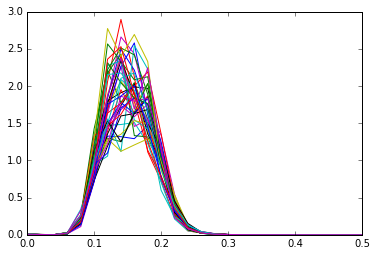

In [46]:
[freq,pwy] = welch(y,axis=0,nperseg=50);
plt.plot(freq,pwy)
plt.show()

We see that the fluctuations are reduced and the overall shape of the PSD is well captured. Next, we reduce again the window size.

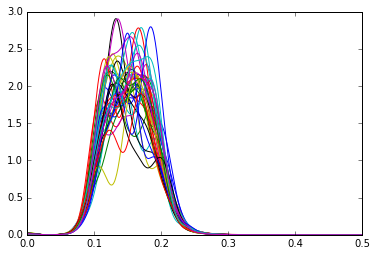

In [133]:
[freq,pwy] = welch(y,axis=0,nperseg=50,nfft=1024);
plt.plot(freq,pwy)
plt.show()

We see now that reducing too much the window size results in a poor frequency resolution, such that the shape of the PSD is not well captured anymore. 

In order to choose the optimal parameters of the Welch periodogram, we thus need to have a prior knowledge of the frequency resultion of the PSD we are trying to estimate. The inverse of the frequency resolution provides a minimum value for the window length to be used. Ultimately, reaching a satifactory tradeoff between good frequency resolution and small fluctuations may require to acquire more time points.